# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

from random import randrange
import os
import pandas as pd
import numpy as np
from sklearn.utils import resample

import cv2 as cv
from PIL import Image
import PIL.ImageOps    
import matplotlib.pyplot as plt
from skimage.transform import resize

from torch.utils.tensorboard import SummaryWriter
import torchmetrics

import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split

c:\Users\micha\Envs\UKSH\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Globals


In [3]:
dev = "cuda:0" if torch.cuda.is_available() else "cpu" 
device = torch.device(dev) 

size = (150,150)

path = os.path.abspath(os.getcwd())

# Pre Processing
### Calculating mean and std of images

In [4]:
imgs = []

convert = transforms.Compose([   

    transforms.Grayscale(),
    # resize
    transforms.Resize(size),
    # to-tensor
    transforms.ToTensor(),

    
])

for filename in os.listdir("testimages"):
    img = Image.open(f"testimages/{filename}").convert('RGB')
    img = convert(img)
    imgs.append(img)
imgs = torch.stack(imgs)

imgs_mean = imgs.mean()
imgs_std = imgs.std()

In [5]:
imgs_mean, imgs_std

(tensor(0.9898), tensor(0.0786))

In [4]:
transform = transforms.Compose([

    transforms.Grayscale(),
    # resize
    transforms.Resize(size),
    # to-tensor
    transforms.ToTensor(),
    # normalize
    transforms.Normalize((imgs_mean), (imgs_std))
])

# Load Data

In [5]:
def loadimages():
    images = []
    for i in range(0,500):
        img = Image.open(f"testimages/img{i}.png").convert('RGB')
        img = transform(img)
        images.append(img)
    images = torch.stack(images)
    return images

In [6]:
images = loadimages()
pairs = np.load("imagePairs.npy", allow_pickle=True ).astype(int)
labels = np.load("imageLabels.npy", allow_pickle=True ).astype(float)

pairs = pairs[500:24000]
labels = labels[500:24000]

# Split into Train, Val and Test
rndidx = np.random.choice(np.arange(0,  len(pairs)), size = len(pairs) )
trainidx, remain = np.array_split(rndidx, [int(0.7 * len(rndidx))])
validx, testidx = np.array_split(remain, [int(0.5 * len(remain))])

trainpairs = pairs[trainidx]
valpairs = pairs[validx]
testpairs = pairs[testidx]

trainlabels = labels[trainidx]
vallabels = labels[validx]
testlabels = labels[testidx]


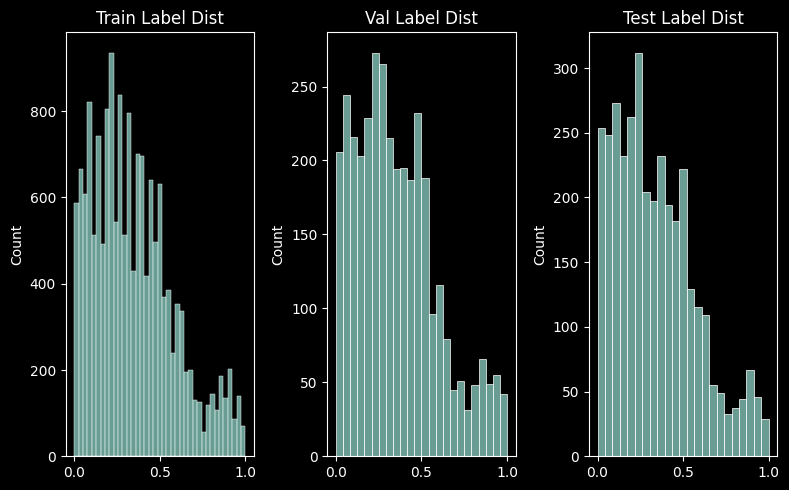

In [7]:
fig, ax = plt.subplots(1,3, figsize=(8,5))
sns.histplot(trainlabels, ax=ax[0])
ax[0].set_title("Train Label Dist")
sns.histplot(vallabels, ax=ax[1])
ax[1].set_title("Val Label Dist")
sns.histplot(testlabels, ax=ax[2])
ax[2].set_title("Test Label Dist")
plt.tight_layout()

# Training NN

In [8]:
class HazelNet(nn.Module):
    """Class for instanciating the NN

    Args:
        nn (nn.Module): super class to inherit from in pytorch
    """

    def __init__(self):
        """ Cosntructor for initialization
        """
        super(HazelNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
  
        # over-write the first conv layer to be able to read images
        # as resnet18 reads (3,x,x) where 3 is RGB channels
        # whereas MNIST has (1,x,x) where 1 is a gray-scale channel
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.fc_in_features = self.resnet.fc.in_features 
        # remove the last layer of resnet18 (linear layer which is before avgpool layer)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        # add linear layers to compare between the features of the two images
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            nn.Linear(1024, 128),
            )        
       
        # initialize the weights
        self.resnet.apply(self.init_weights)
        self.fc.apply(self.init_weights)   
        
    def init_weights(self, m):
        """Function for weight init

        Args:
            m (module): module to use for init
        """
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
    
    def forward_once(self, inputs):
        """Helper function for forward path

        Args:
            inputs (tensor): input tensor

        Returns:
            tensor: output tensor
        """
        output = self.resnet(inputs)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output
    
    def distance_layer(self, vec1, vec2):
        """Function for calculating the cosine similarity between two tensors

        Args:
            vec1 (tensor): tensor for template images
            vec2 (tensor): tensor for images to compare with

        Returns:
            tensor: tensor containing the calculated similarity as float
        """
        cos = torch.nn.CosineSimilarity()
        similarity = cos(vec1, vec2) 
        return similarity

    def forward(self, template, img):
        """Main function for forward path

        Args:
            template (tensor): tensor of template images
            img (tensor): tensor of images to compare

        Returns:
            tensor: tensor containing the calculated similarity as float
        """
        output1 = self.forward_once(template)
        output2 = self.forward_once(img)
        output = self.distance_layer(output1,output2)
 
        return output

    def readImg_url (self, url1, url2, iswhite = False, plot = False):
        """Function for reading images into processable tensors. Can draw a picture of processed images

        Args:
            url1 (string): url to template image
            url2 (string): url to image for comparison
            iswhite (bool, optional): inverts image colors if set to true. Defaults to False.
            plot (bool, optional): plots imported images if set to true. Defaults to False.

        Returns:
            tensor, tensor: two tensors containing the processed images ready for prediction
        """
        # invert white and black if image is on white background
        if iswhite:
            realim1 = cv.bitwise_not(cv.imread(url1,0)).astype(np.float32)
            realim2 = cv.bitwise_not(cv.imread(url2,0)).astype(np.float32)
        else: 
            realim1 = cv.imread(url1,0).astype(np.float32)
            realim2 = cv.imread(url2,0).astype(np.float32)

        realim1 =  cv.resize(realim1, imgsize)
        realim2 =  cv.resize(realim2, imgsize)
        template = torch.tensor(realim1).unsqueeze(0).unsqueeze(0).to(device)
        img = torch.tensor(realim2.astype(np.float32)).unsqueeze(0).unsqueeze(0).to(device)

        if plot:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(realim1)
            ax[1].imshow(realim2)
        return template, img        

In [9]:
augmenter = transforms.Compose([
    transforms.RandomRotation(degrees=20),

])


In [10]:
# Class for creating a Dataset which the dataloader from pytroch needs to create a wrapper for iterating though the data
class CustomImageDataset(Dataset):
    def __init__(self, root, pairs, labels, images):
       self.pairs = pairs
       self.labels = labels
       self.images = images
       
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        element = self.pairs[idx]
        label = self.labels[idx]
        template = self.images[self.pairs[idx][0]]
        img = self.images[self.pairs[idx][1]]
        img = augmenter(img)
        img = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2))(img) if randrange(4) == 1 else img

        return  template, img , label.astype(np.float32) 

## NN Parameters

In [11]:
batch_size = 40 if torch.cuda.is_available() else 64

learning_rate = 0.005
num_epochs = 100

loss_history = []
r2_history = []


r2score = torchmetrics.R2Score().to(device)
mape = torchmetrics.MeanAbsolutePercentageError().to(device)
mse = torchmetrics.MeanSquaredError().to(device)
mae = torchmetrics.MeanAbsoluteError().to(device)

metrics = {"loss": 0 ,"r2" : r2score, "mse" : mse, "mae" : mae, "mape" : mape}

In [12]:
model = HazelNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

training_data = CustomImageDataset("", pairs=trainpairs, labels=trainlabels, images=images)
val_data = CustomImageDataset("",  pairs=valpairs, labels=vallabels, images=images)
test_data = CustomImageDataset("", pairs=testpairs, labels=testlabels, images=images)

# Create data loaders.
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


In [13]:
def train_one_epoch(epoch_index, train_loader):
    """Function for training a NN for one epoch

    Args:
        epoch_index (int): index of current epoch
        train_loader (data loader): loader containing training data

    Returns:
        float, tensor: averaged loss and r2 coefficient
    """

    running = {"loss" :0, "r2" : 0, "mse" : 0, "mae" : 0, "mape" : 0}
    total = {"loss" : 0, "r2" : 0, "mse" : 0, "mae" : 0, "mape" : 0}


    for idx, data in enumerate(train_loader):
        templates, images, targets = data
        
        templates = templates.to(device)
        images = images.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()

        outputs = model(templates, images)

        loss = criterion(outputs, targets)
        loss.backward()

        optimizer.step()

        for key, metric in metrics.items():
            if key == "loss":
                running[key] += loss
                total[key] += loss
            else:
                running[key] += metric(outputs, torch.tensor(targets).squeeze())
                total[key] += metric(outputs, torch.tensor(targets).squeeze())


        if idx % 100 == 80:
            running = {k: v / 100 for k,v in running.items()}
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.4f} R2Score: {:.4f} MSE: {:.4f} MAE {:.4f} MAPE {:.4f} '.format(
            epoch_index, idx * len(templates), len(train_loader.dataset),
            100. * idx / len(train_loader), running["loss"], running["r2"], running["mse"], running["mae"], running["mape"]))
            running = {"loss" :0, "r2" : 0, "mse" : 0, "mae" : 0, "mape" : 0}

    total = {k: v / (idx + 1) for k,v in total.items()}

    del templates
    del images
    del targets

    torch.cuda.empty_cache()

    return total

In [14]:
def trainModel (train_loader, val_loader, saveModel = False):
    """Main Function for training the NN

    Args:
        train_loader (data loader): loader containing training data
        val_loader (data loader): loader containing val data
        saveModel (bool, optional): regulates whether to save the best model. Defaults to False.
    """
    log = pd.DataFrame()
    torch.cuda.empty_cache()
    tb = SummaryWriter()
    best_vloss = 1000000

    for epoch in range (num_epochs):

        model.train(True)
        train_avgs = train_one_epoch(epoch_index=epoch, train_loader=train_loader)

        torch.cuda.empty_cache()
        model.train(False)

        total = {"loss" : 0, "r2" : 0, "mse" : 0, "mae" : 0, "mape" : 0}

        with torch.no_grad():
            for idx, vdata in enumerate(val_loader):
                vtemplates, vimages, vtargets = vdata
                vtemplates = vtemplates.to(device)
                vimages = vimages.to(device)
                vtargets = vtargets.to(device)

                voutputs = model(vtemplates,vimages)
                vloss =  criterion(voutputs, vtargets)

                for key, metric in metrics.items():
                    if key == "loss":
                        total[key] += vloss
                    else:
                        total[key] += metric(voutputs, torch.tensor(vtargets).squeeze())


            val_avgs = {k: v / (idx + 1) for k,v in total.items()}
 
            print('EPOCH RESULTS: Train Loss {:.4f} Valid Loss {:.4f} Train R2 {:.4f} Valid R2 {:.4f} Train MSE {:.4f} Val MSE {:.4f} Train MAE {:.4f} Val MAE {:.4f} Train MAPE {:.4f} Val MAPE {:.4f} '.format(
                    train_avgs["loss"], val_avgs["loss"], train_avgs["r2"], val_avgs["r2"], train_avgs["mse"], val_avgs["mse"], train_avgs["mae"], val_avgs["mae"], train_avgs["mape"], val_avgs["mape"]))

            tb.add_scalars('Training vs. Validation Loss',
                            { 'Training' : train_avgs["loss"], 'Validation' : val_avgs["loss"]},
                            epoch + 1)


            tb.add_scalars('Training vs. Validation R2',
                            { 'Training' : train_avgs["r2"], 'Validation' : val_avgs["r2"]},
                            epoch + 1)
            tb.flush()    

        log = log.append({f"train_{k}" : v.cpu().item()  for k,v in train_avgs.items()} | {f"val_{k}" : v.cpu().item()  for k,v in val_avgs.items()}, ignore_index=True)
        # Track best performance, and save the model's state
        if saveModel and val_avgs["loss"] < best_vloss:
             best_vloss = val_avgs["loss"]
             torch.save(model.state_dict(), f"{path}/Model/bestmodel")

    return log


In [15]:
log = trainModel(train_loader=train_loader, val_loader=val_loader)

KeyboardInterrupt: 

In [ ]:
#torch.save(model.state_dict(), "bestmodel_area")
#log.to_csv("bestmodellog_area")

# Predict values

In [ ]:
def predict (model, template, img):
    """Function for predicting the correlation score between two images

    Args:
        model (HazelNet): The model to use for prediction
        template (tensor): template image
        img (tensor): image to compare to

    Returns:
        float: label containing predicted similarity score
    """
    model.eval()
    with torch.no_grad():
        ypred = model(template,img)
    return round(ypred.item(),2)

In [ ]:
transform = transforms.Compose([

    transforms.Grayscale(),
    # resize
    transforms.Resize(size),
    # to-tensor
    transforms.ToTensor(),
    # normalize
    transforms.Normalize((0.98), (0.07))
])

In [ ]:
def readImg_url ( url1, url2, isblack = False, plot = False):
        """Function for reading images into processable tensors. Can draw a picture of processed images

        Args:
            url1 (string): url to template image
            url2 (string): url to image for comparison
            isblack (bool, optional): inverts image colors if set to true. Defaults to False.
            plot (bool, optional): plots imported images if set to true. Defaults to False.

        Returns:
            tensor, tensor: two tensors containing the processed images ready for prediction
        """

        realim1 = Image.open(url1)
        realim2 = Image.open(url2)
        # invert white and black if image is on white background
        if isblack:
            realim1 = PIL.ImageOps.invert(realim1)
            realim2 = PIL.ImageOps.invert(realim2)

        template = transform(realim1).unsqueeze(0).to(device)
        img = transform(realim2).unsqueeze(0).to(device)

        if plot:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(realim1)
            ax[1].imshow(realim2)
        return template, img        

In [ ]:
path = 'c:\\Users\\micha\\Documents\\FH Kiel\\UKSH\\Abgabe Application Project'
url1 = f"{path}/Real Images/Peaks/Peak1.png"
url2 = f"{path}/Real Images/Peaks/Peak6.png"

template, img = readImg_url(url1= url1, url2 =url2,  isblack=False, plot=True )
predict(model = model, template = template, img = img)

In [ ]:
test = next(iter(test_loader))
img1 = test[0][0].squeeze(0).numpy()
img2 = test[1][0].squeeze(0).numpy()

fig, ax = plt.subplots(1,2)
ax[0].imshow(img1)
ax[1].imshow(img2)
fig.suptitle(test[2][0])

In [ ]:
predict(model = model, template = test[0][0].unsqueeze(0).to(device), img = test[1][0].unsqueeze(0).to(device))

In [16]:
model = HazelNet().to(device)
#torch.save(model.state_dict(), f"test")
model.load_state_dict(torch.load(f"bestmodel_area"))

<All keys matched successfully>